<div align = "center">

# **Exploración de Base Final Anual**

</div>

## Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Carga de Datos

In [2]:
# Cargar base final
df = pd.read_csv('../data/tmp/base_final_anual.csv')

print(f"Dimensiones: {df.shape}")
print(f"\nColumnas:")
print(df.dtypes)
df.head()

Dimensiones: (738902, 21)

Columnas:
ID_POLIZA_AMPARO_PERIODO        object
POLIZA                           int64
AMPARO                          object
ANIO_POLIZA                      int64
PERIODO                          int64
VIGENCIA_PERIODO_INICIO         object
VIGENCIA_PERIODO_FIN            object
DIAS_EXPOSICION                  int64
FRACCION_ANUAL                 float64
EXPOSICION_PRORRATEADA         float64
VIGENCIA_ORIGINAL_ID            object
COD_SUCURSAL                     int64
VIGENCIA_ORIGINAL_INICIO        object
VIGENCIA_ORIGINAL_FIN           object
DEPARTAMENTO_SINIESTRO          object
FECHA_DE_SINIESTRO              object
FECHA_AVISO                     object
SEVERIDAD                      float64
SEVERIDAD_EXTRAPOLADA_ANUAL    float64
TUVO_SINIESTRO                   int64
ES_PERIODO_ORIGINAL               bool
dtype: object


,ID_POLIZA_AMPARO_PERIODO,POLIZA,AMPARO,ANIO_POLIZA,PERIODO,VIGENCIA_PERIODO_INICIO,VIGENCIA_PERIODO_FIN,DIAS_EXPOSICION,FRACCION_ANUAL,EXPOSICION_PRORRATEADA,...,COD_SUCURSAL,VIGENCIA_ORIGINAL_INICIO,VIGENCIA_ORIGINAL_FIN,DEPARTAMENTO_SINIESTRO,FECHA_DE_SINIESTRO,FECHA_AVISO,SEVERIDAD,SEVERIDAD_EXTRAPOLADA_ANUAL,TUVO_SINIESTRO,ES_PERIODO_ORIGINAL
0,1020472_PRESTACIONES SOCIALES_2020_0_20200401,1020472,PRESTACIONES SOCIALES,2020,0,2020-04-01,2021-04-01,366,1.00274,1.402544e+07,...,12,01/04/2020,01/03/2027,13-BOLIVAR,30/04/2020,26/02/2024,6864750.0,6.845994e+06,1,True
1,1020472_PRESTACIONES SOCIALES_2021_1_20210402,1020472,PRESTACIONES SOCIALES,2021,1,2021-04-02,2022-04-02,366,1.00274,1.402544e+07,...,12,01/04/2020,01/03/2027,13-BOLIVAR,30/04/2020,26/02/2024,0.0,0.000000e+00,1,False
2,1020472_PRESTACIONES SOCIALES_2022_2_20220403,1020472,PRESTACIONES SOCIALES,2022,2,2022-04-03,2023-04-03,366,1.00274,1.402544e+07,...,12,01/04/2020,01/03/2027,13-BOLIVAR,30/04/2020,26/02/2024,0.0,0.000000e+00,1,False
3,1020472_PRESTACIONES SOCIALES_2023_3_20230404,1020472,PRESTACIONES SOCIALES,2023,3,2023-04-04,2024-04-03,366,1.00274,1.402544e+07,...,12,01/04/2020,01/03/2027,13-BOLIVAR,30/04/2020,26/02/2024,0.0,0.000000e+00,1,False
4,1020472_PRESTACIONES SOCIALES_2024_4_20240404,1020472,PRESTACIONES SOCIALES,2024,4,2024-04-04,2025-04-04,366,1.00274,1.402544e+07,...,12,01/04/2020,01/03/2027,13-BOLIVAR,30/04/2020,26/02/2024,0.0,0.000000e+00,1,False


## Exploración General

In [3]:
print("=" * 80)
print("RESUMEN ESTADÍSTICO GENERAL")
print("=" * 80)

print(f"\nTotal de registros: {len(df):,}")
print(f"Pólizas únicas: {df['POLIZA'].nunique():,}")
print(f"Amparos únicos: {df['AMPARO'].nunique()}")

print(f"\nAmparos disponibles:")
print(df['AMPARO'].value_counts())

RESUMEN ESTADÍSTICO GENERAL

Total de registros: 738,902
Pólizas únicas: 212,191
Amparos únicos: 15

Amparos disponibles:
AMPARO
PRESTACIONES SOCIALES                363085
ESTABILIDAD DE LA OBRA               128865
CALIDAD DEL SERVICIO                  91450
CUMPLIMIENTO                          56556
CALIDAD DE LOS ELEMENTOS              32261
CALIDAD Y CORRECTO FUNCIONAMIENTO     21477
SERIEDAD DE LA OFERTA                 18189
CALIDAD                               14338
BUEN MANEJO DEL ANTICIPO               6442
CORRECTO FUNCIONAMIENTO                2500
PROVISION DE REPUESTOS                 1545
PAGO ANTICIPADO                        1046
DISPOSICIONES LEGALES                   602
SUMINISTRO DE REPUESTOS                 443
BUEN MANEJO DE MATERIALES               103
Name: count, dtype: int64


## Análisis por Amparo (Cobertura)

In [4]:
print("=" * 80)
print("ESTADÍSTICAS POR AMPARO")
print("=" * 80)

# Métricas por amparo
stats_amparo = df.groupby('AMPARO').agg({
    'POLIZA': 'count',  # Número de períodos
    'TUVO_SINIESTRO': ['sum', 'mean'],  # Siniestros y frecuencia
    'EXPOSICION_PRORRATEADA': 'sum',  # Exposición total
    'SEVERIDAD': ['sum', 'mean', 'std']  # Severidad
}).round(4)

stats_amparo.columns = ['N_PERIODOS', 'N_SINIESTROS', 'FRECUENCIA', 
                        'EXPOSICION_TOTAL', 'SEVERIDAD_TOTAL', 
                        'SEVERIDAD_MEDIA', 'SEVERIDAD_STD']

# Calcular prima pura = severidad_total / exposicion_total
stats_amparo['PRIMA_PURA'] = stats_amparo['SEVERIDAD_TOTAL'] / stats_amparo['EXPOSICION_TOTAL']

stats_amparo = stats_amparo.sort_values('N_PERIODOS', ascending=False)
stats_amparo

ESTADÍSTICAS POR AMPARO


,N_PERIODOS,N_SINIESTROS,FRECUENCIA,EXPOSICION_TOTAL,SEVERIDAD_TOTAL,SEVERIDAD_MEDIA,SEVERIDAD_STD,PRIMA_PURA
AMPARO,,,,,,,,
PRESTACIONES SOCIALES,363085,915,0.0025,2.279308e+14,9.232442e+08,2542.7770,2.836002e+05,4.050545e-06
ESTABILIDAD DE LA OBRA,128865,259,0.0020,1.364745e+13,3.458424e+08,2683.7571,2.617237e+05,2.534116e-05
CALIDAD DEL SERVICIO,91450,29,0.0003,5.133212e+13,4.151398e+06,45.3953,8.059864e+03,8.087330e-08
CUMPLIMIENTO,56556,1084,0.0192,8.505154e+13,8.265295e+09,146143.5604,6.832811e+06,9.717984e-05
CALIDAD DE LOS ELEMENTOS,32261,14,0.0004,1.667673e+13,1.883217e+06,58.3744,6.188617e+03,1.129248e-07
CALIDAD Y CORRECTO FUNCIONAMIENTO,21477,10,0.0005,7.657398e+13,8.051799e+04,3.7490,5.494221e+02,1.051506e-09
SERIEDAD DE LA OFERTA,18189,2,0.0001,2.012440e+11,0.000000e+00,0.0000,0.000000e+00,0.000000e+00
CALIDAD,14338,6,0.0004,9.541659e+11,3.586010e+06,250.1053,2.704720e+04,3.758267e-06
BUEN MANEJO DEL ANTICIPO,6442,24,0.0037,3.635129e+12,1.463626e+07,2272.0055,1.369826e+05,4.026338e-06


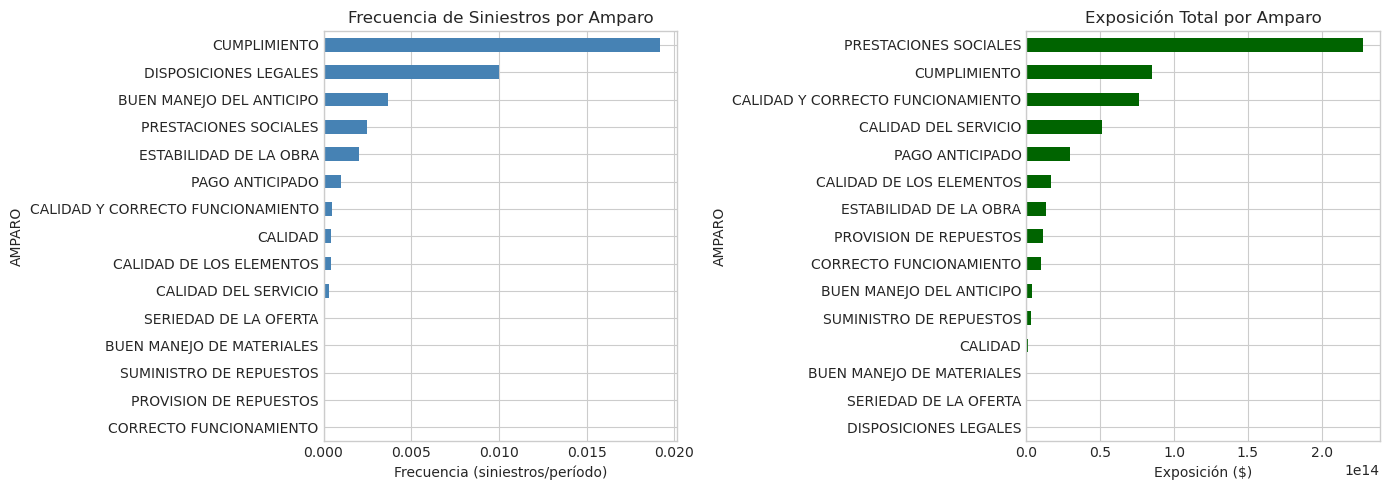

In [5]:
# Visualización de frecuencia por amparo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Frecuencia
stats_amparo['FRECUENCIA'].sort_values().plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Frecuencia de Siniestros por Amparo')
axes[0].set_xlabel('Frecuencia (siniestros/período)')

# Exposición
stats_amparo['EXPOSICION_TOTAL'].sort_values().plot(kind='barh', ax=axes[1], color='darkgreen')
axes[1].set_title('Exposición Total por Amparo')
axes[1].set_xlabel('Exposición ($)')

plt.tight_layout()
plt.show()

## Clustering Jerárquico de Coberturas

In [6]:
print("=" * 80)
print("CLUSTERING DE COBERTURAS POR COMPORTAMIENTO")
print("=" * 80)

# Preparar features para clustering
features_cluster = stats_amparo[['FRECUENCIA', 'SEVERIDAD_MEDIA', 'PRIMA_PURA', 'N_PERIODOS']].copy()
features_cluster = features_cluster.fillna(0)

# Normalizar
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_cluster)

print(f"\nFeatures para clustering:")
print(features_cluster)

CLUSTERING DE COBERTURAS POR COMPORTAMIENTO

Features para clustering:
                                   FRECUENCIA  SEVERIDAD_MEDIA    PRIMA_PURA  \
AMPARO                                                                         
PRESTACIONES SOCIALES                  0.0025        2542.7770  4.050545e-06   
ESTABILIDAD DE LA OBRA                 0.0020        2683.7571  2.534116e-05   
CALIDAD DEL SERVICIO                   0.0003          45.3953  8.087330e-08   
CUMPLIMIENTO                           0.0192      146143.5604  9.717984e-05   
CALIDAD DE LOS ELEMENTOS               0.0004          58.3744  1.129248e-07   
CALIDAD Y CORRECTO FUNCIONAMIENTO      0.0005           3.7490  1.051506e-09   
SERIEDAD DE LA OFERTA                  0.0001           0.0000  0.000000e+00   
CALIDAD                                0.0004         250.1053  3.758267e-06   
BUEN MANEJO DEL ANTICIPO               0.0037        2272.0055  4.026338e-06   
CORRECTO FUNCIONAMIENTO                0.0000    

### Dendrograma y Estructura Jerárquica

HIERARCHICAL CLUSTERING - DENDROGRAMA


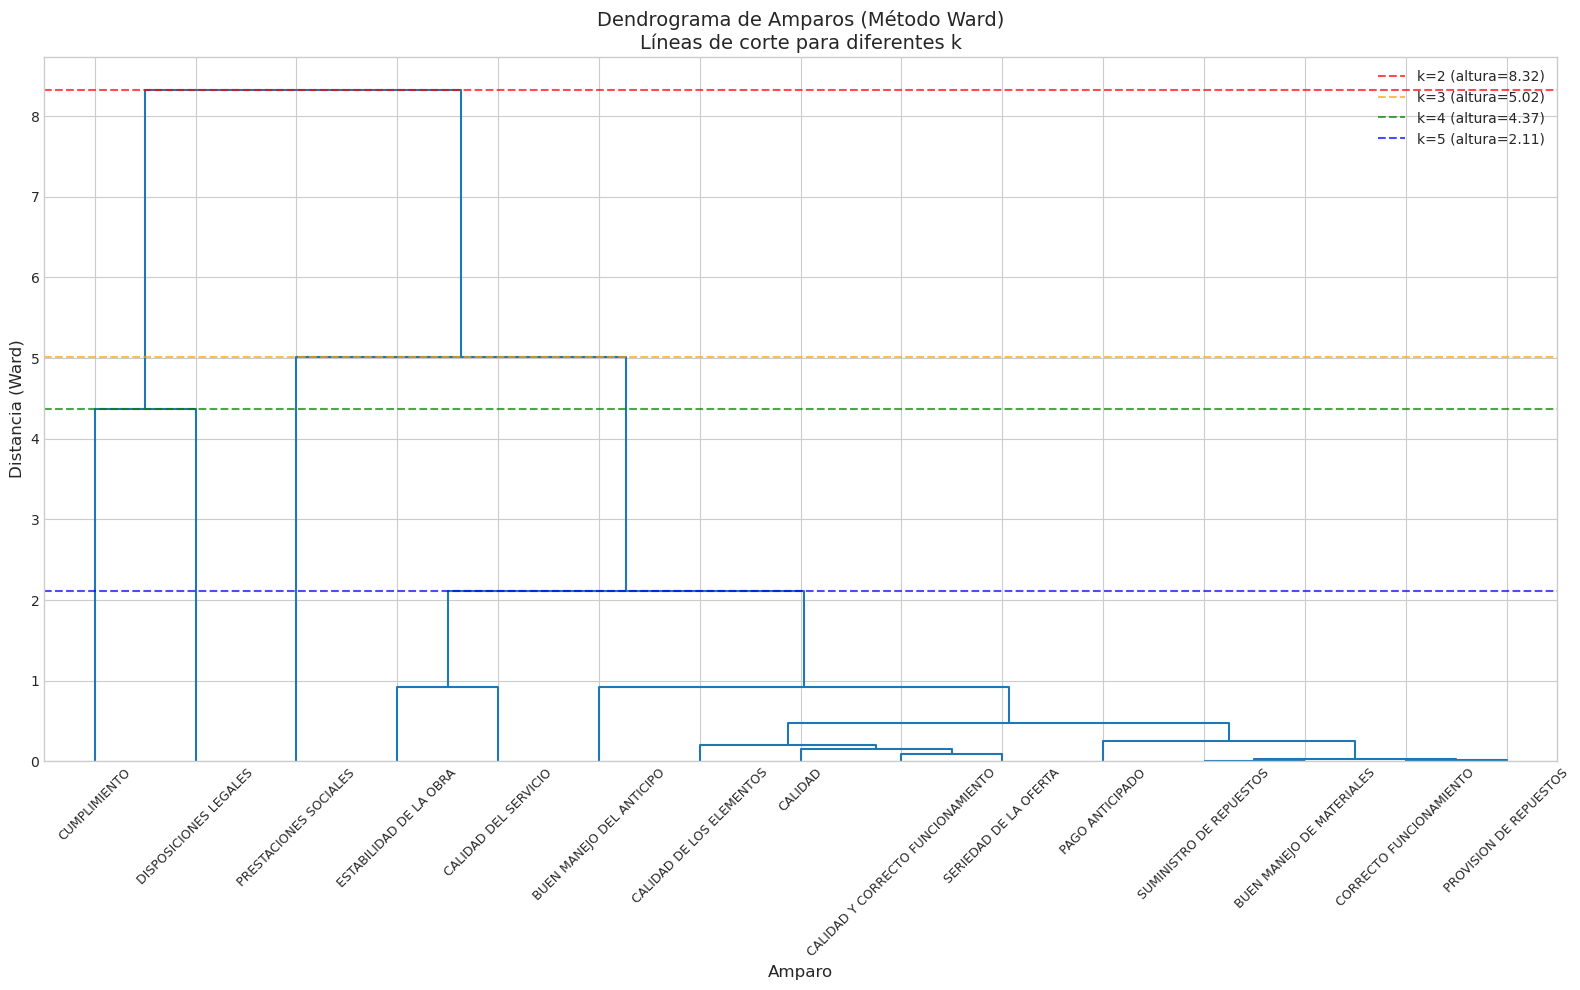


Interpretación del dendrograma:
- Altura del corte indica disimilitud entre clusters fusionados
- Cortes más altos → clusters más diferentes entre sí
- Método Ward minimiza la varianza dentro de cada cluster


In [7]:
print("=" * 80)
print("HIERARCHICAL CLUSTERING - DENDROGRAMA")
print("=" * 80)

# Calcular matriz de linkage (método Ward minimiza varianza intra-cluster)
linkage_matrix = linkage(features_scaled, method='ward')

# Dendrograma con líneas de corte para diferentes k
fig, ax = plt.subplots(figsize=(16, 10))

dend = dendrogram(
    linkage_matrix,
    labels=features_cluster.index.tolist(),
    leaf_rotation=45,
    leaf_font_size=9,
    ax=ax,
    color_threshold=0  # Colorear por defecto
)

# Agregar líneas horizontales para diferentes cortes
# Obtener alturas de corte para k=2,3,4,5
heights = sorted(linkage_matrix[:, 2], reverse=True)
colors = ['red', 'orange', 'green', 'blue']
k_values = [2, 3, 4, 5]

for i, k in enumerate(k_values):
    if k-1 < len(heights):
        h = heights[k-2] if k > 1 else heights[0]
        ax.axhline(y=h, color=colors[i], linestyle='--', alpha=0.7, 
                   label=f'k={k} (altura={h:.2f})')

ax.set_title('Dendrograma de Amparos (Método Ward)\nLíneas de corte para diferentes k', fontsize=14)
ax.set_xlabel('Amparo', fontsize=12)
ax.set_ylabel('Distancia (Ward)', fontsize=12)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

print("\nInterpretación del dendrograma:")
print("- Altura del corte indica disimilitud entre clusters fusionados")
print("- Cortes más altos → clusters más diferentes entre sí")
print("- Método Ward minimiza la varianza dentro de cada cluster")

EVALUACIÓN DE NÚMERO ÓPTIMO DE CLUSTERS
k=2: Silhouette Score = 0.6932
k=3: Silhouette Score = 0.6702
k=4: Silhouette Score = 0.6558
k=5: Silhouette Score = 0.5350


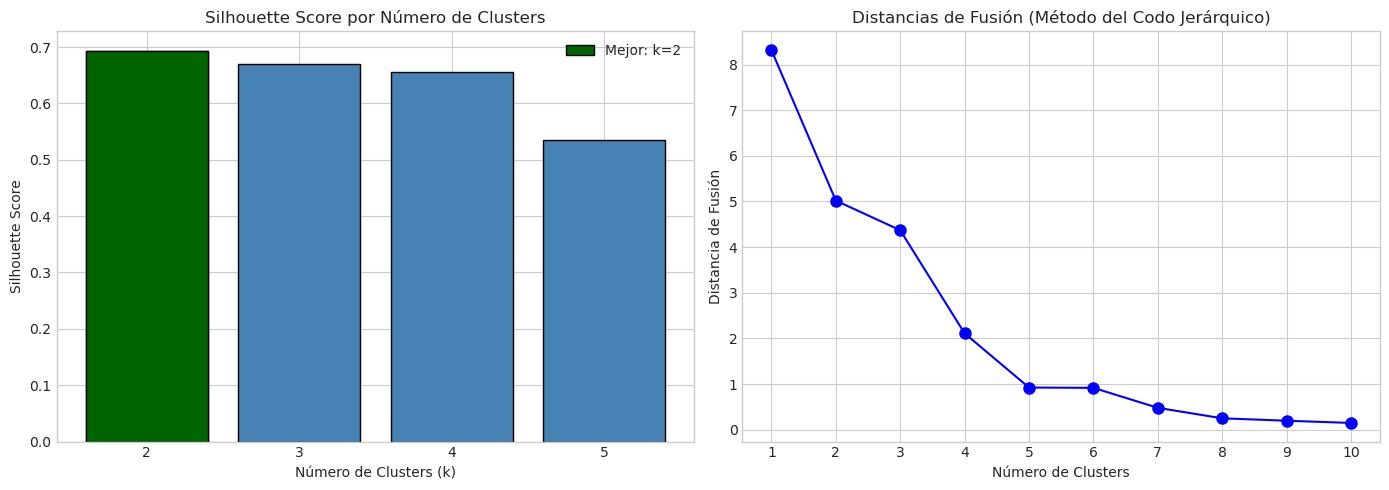


→ Mejor k según Silhouette Score: 2 (score = 0.6932)


In [8]:
print("=" * 80)
print("EVALUACIÓN DE NÚMERO ÓPTIMO DE CLUSTERS")
print("=" * 80)

# Calcular métricas para k = 2, 3, 4, 5
k_values = [2, 3, 4, 5]
silhouette_scores = []
cluster_assignments = {}

for k in k_values:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(features_scaled)
    cluster_assignments[k] = labels
    sil_score = silhouette_score(features_scaled, labels)
    silhouette_scores.append(sil_score)
    print(f"k={k}: Silhouette Score = {sil_score:.4f}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Silhouette scores
axes[0].bar(k_values, silhouette_scores, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Número de Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score por Número de Clusters')
axes[0].set_xticks(k_values)

# Marcar el mejor
best_k = k_values[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
axes[0].bar(best_k, best_score, color='darkgreen', edgecolor='black', label=f'Mejor: k={best_k}')
axes[0].legend()

# Distancias de fusión (para método del codo en jerárquico)
last_merges = linkage_matrix[-10:, 2]  # Últimas 10 fusiones
axes[1].plot(range(1, len(last_merges)+1), last_merges[::-1], 'bo-', markersize=8)
axes[1].set_xlabel('Número de Clusters')
axes[1].set_ylabel('Distancia de Fusión')
axes[1].set_title('Distancias de Fusión (Método del Codo Jerárquico)')
axes[1].set_xticks(range(1, len(last_merges)+1))

plt.tight_layout()
plt.show()

print(f"\n→ Mejor k según Silhouette Score: {best_k} (score = {best_score:.4f})")

### Resultados para k = 2, 3, 4, 5

In [9]:
print("=" * 80)
print("ASIGNACIÓN DE CLUSTERS PARA k = 2, 3, 4, 5")
print("=" * 80)

# Crear DataFrame con todas las asignaciones
resultados_clustering = features_cluster.copy()
for k in k_values:
    resultados_clustering[f'CLUSTER_k{k}'] = cluster_assignments[k]

# Agregar métricas originales
resultados_clustering = resultados_clustering.join(stats_amparo[['N_SINIESTROS', 'EXPOSICION_TOTAL', 'SEVERIDAD_TOTAL']])

# Mostrar asignaciones para cada k
for k in k_values:
    print(f"\n{'='*60}")
    print(f"k = {k} CLUSTERS")
    print(f"{'='*60}")
    
    col_cluster = f'CLUSTER_k{k}'
    
    for cluster in range(k):
        mask = resultados_clustering[col_cluster] == cluster
        amparos_cluster = resultados_clustering[mask].index.tolist()
        
        # Estadísticas del cluster
        freq_media = resultados_clustering.loc[mask, 'FRECUENCIA'].mean()
        sev_media = resultados_clustering.loc[mask, 'SEVERIDAD_MEDIA'].mean()
        n_periodos = resultados_clustering.loc[mask, 'N_PERIODOS'].sum()
        n_siniestros = resultados_clustering.loc[mask, 'N_SINIESTROS'].sum()
        
        print(f"\nCluster {cluster} ({len(amparos_cluster)} amparos):")
        print(f"  Freq. media: {freq_media:.4f} | Sev. media: ${sev_media:,.0f}")
        print(f"  N períodos: {n_periodos:,} | N siniestros: {n_siniestros:,.0f}")
        print(f"  Amparos:")
        for amparo in amparos_cluster:
            freq = resultados_clustering.loc[amparo, 'FRECUENCIA']
            n = resultados_clustering.loc[amparo, 'N_PERIODOS']
            print(f"    • {amparo} (freq={freq:.4f}, n={n:,})")

ASIGNACIÓN DE CLUSTERS PARA k = 2, 3, 4, 5

k = 2 CLUSTERS

Cluster 0 (13 amparos):
  Freq. media: 0.0008 | Sev. media: $609
  N períodos: 681,744 | N siniestros: 1,260
  Amparos:
    • PRESTACIONES SOCIALES (freq=0.0025, n=363,085)
    • ESTABILIDAD DE LA OBRA (freq=0.0020, n=128,865)
    • CALIDAD DEL SERVICIO (freq=0.0003, n=91,450)
    • CALIDAD DE LOS ELEMENTOS (freq=0.0004, n=32,261)
    • CALIDAD Y CORRECTO FUNCIONAMIENTO (freq=0.0005, n=21,477)
    • SERIEDAD DE LA OFERTA (freq=0.0001, n=18,189)
    • CALIDAD (freq=0.0004, n=14,338)
    • BUEN MANEJO DEL ANTICIPO (freq=0.0037, n=6,442)
    • CORRECTO FUNCIONAMIENTO (freq=0.0000, n=2,500)
    • PROVISION DE REPUESTOS (freq=0.0000, n=1,545)
    • PAGO ANTICIPADO (freq=0.0010, n=1,046)
    • SUMINISTRO DE REPUESTOS (freq=0.0000, n=443)
    • BUEN MANEJO DE MATERIALES (freq=0.0000, n=103)

Cluster 1 (2 amparos):
  Freq. media: 0.0146 | Sev. media: $74,990
  N períodos: 57,158 | N siniestros: 1,090
  Amparos:
    • CUMPLIMIENTO (fre

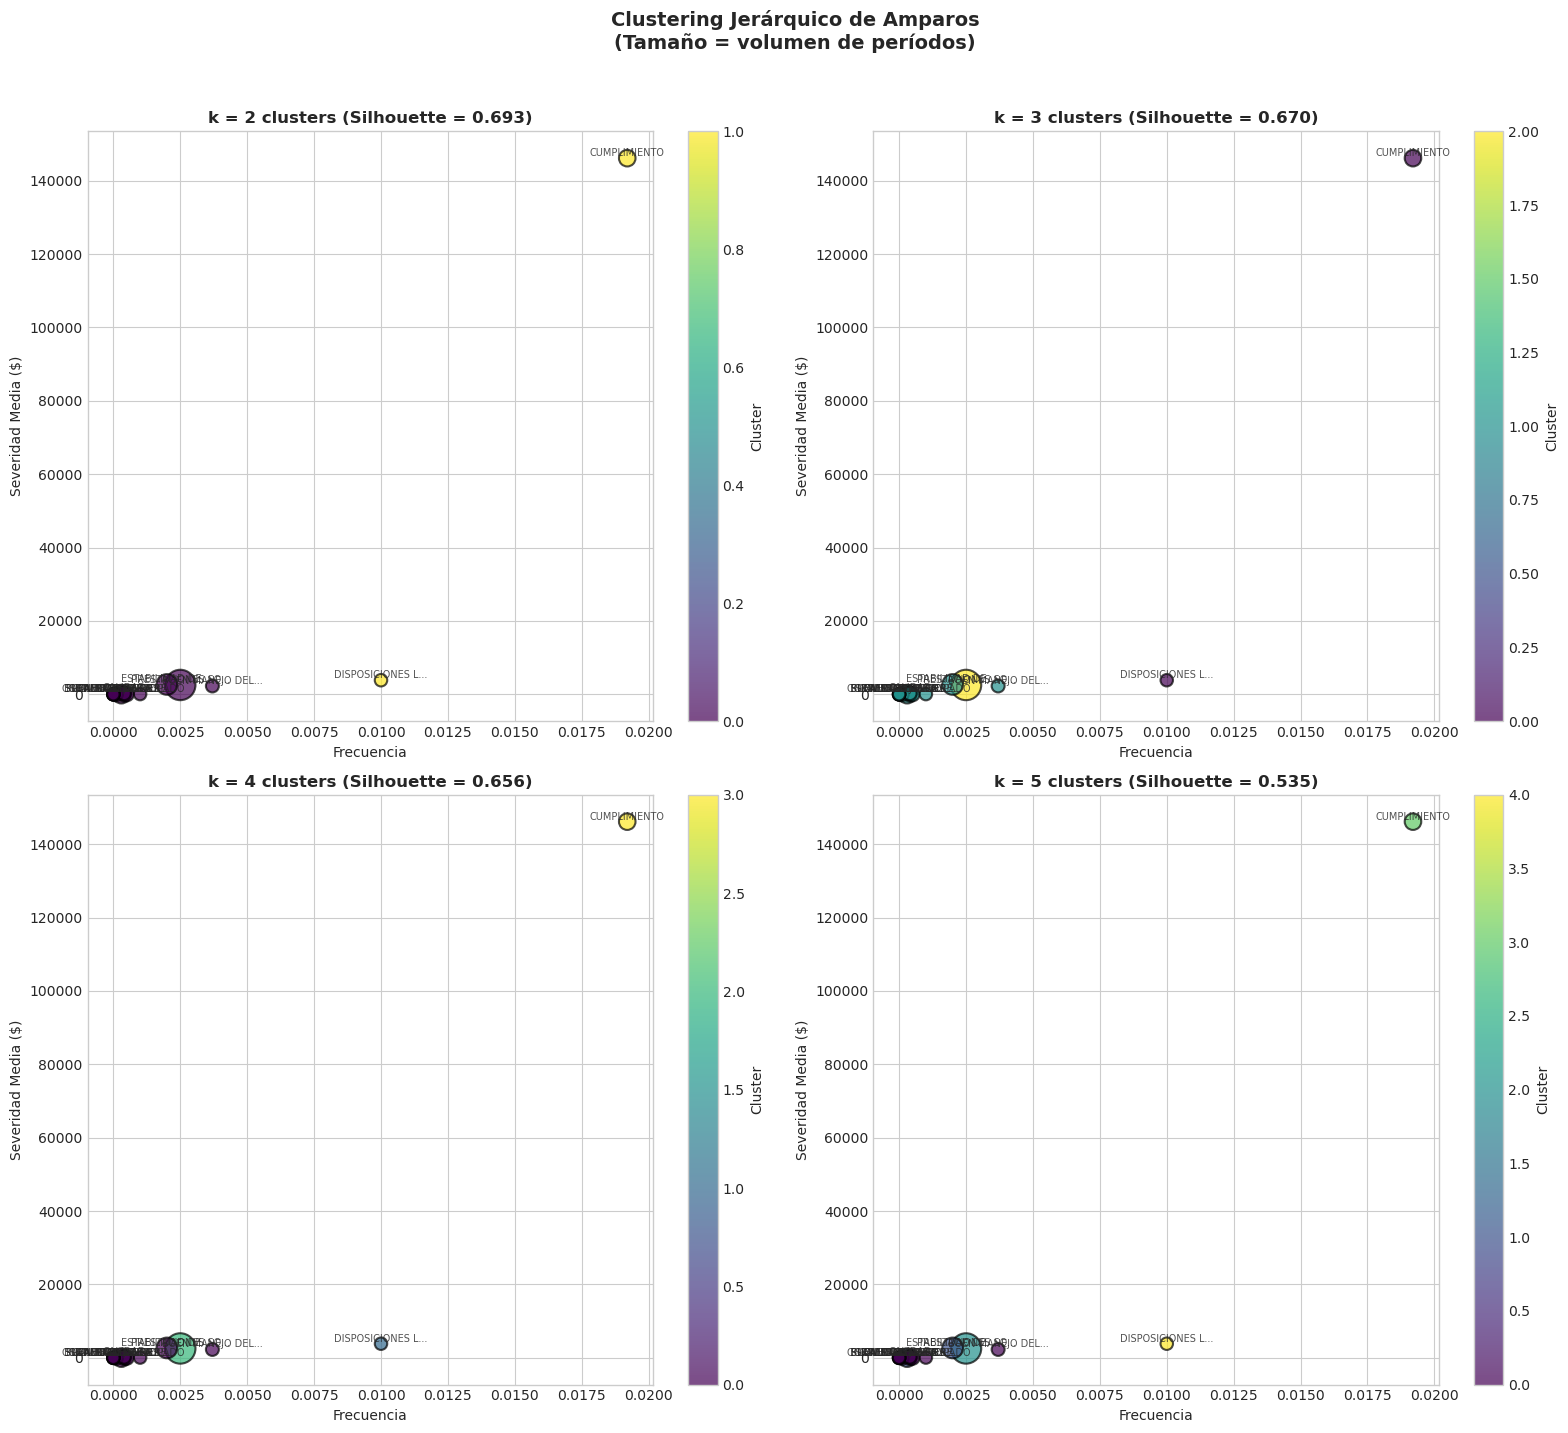

In [10]:
# Visualización comparativa de clusters para k = 2, 3, 4, 5
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    ax = axes[idx]
    col_cluster = f'CLUSTER_k{k}'
    
    # Scatter plot
    scatter = ax.scatter(
        resultados_clustering['FRECUENCIA'],
        resultados_clustering['SEVERIDAD_MEDIA'],
        c=resultados_clustering[col_cluster],
        s=resultados_clustering['N_PERIODOS'] / resultados_clustering['N_PERIODOS'].max() * 400 + 80,
        cmap='viridis',
        alpha=0.7,
        edgecolors='black',
        linewidths=1.5
    )
    
    # Etiquetas
    for amparo in resultados_clustering.index:
        ax.annotate(
            amparo[:15] + '...' if len(amparo) > 15 else amparo,
            (resultados_clustering.loc[amparo, 'FRECUENCIA'],
             resultados_clustering.loc[amparo, 'SEVERIDAD_MEDIA']),
            fontsize=7,
            ha='center',
            va='bottom',
            alpha=0.8
        )
    
    sil = silhouette_scores[idx]
    ax.set_title(f'k = {k} clusters (Silhouette = {sil:.3f})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel('Severidad Media ($)')
    plt.colorbar(scatter, ax=ax, label='Cluster')

plt.suptitle('Clustering Jerárquico de Amparos\n(Tamaño = volumen de períodos)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Resumen para Modelación de Credibilidad

In [11]:
print("=" * 80)
print("RESUMEN COMPARATIVO DE CLUSTERS PARA MODELACIÓN")
print("=" * 80)

# Tabla resumen para cada k
for k in k_values:
    col_cluster = f'CLUSTER_k{k}'
    
    print(f"\n{'─'*70}")
    print(f"k = {k} (Silhouette = {silhouette_scores[k_values.index(k)]:.4f})")
    print(f"{'─'*70}")
    
    resumen = resultados_clustering.groupby(col_cluster).agg({
        'N_PERIODOS': 'sum',
        'N_SINIESTROS': 'sum',
        'FRECUENCIA': 'mean',
        'SEVERIDAD_MEDIA': 'mean',
        'EXPOSICION_TOTAL': 'sum',
        'PRIMA_PURA': 'mean'
    }).round(6)
    
    resumen['N_AMPAROS'] = resultados_clustering.groupby(col_cluster).size()
    resumen['PRIMA_PURA_CLUSTER'] = resumen['SEVERIDAD_TOTAL'] if 'SEVERIDAD_TOTAL' in resumen.columns else 0
    
    # Calcular prima pura real del cluster
    sev_total = resultados_clustering.groupby(col_cluster)['SEVERIDAD_TOTAL'].sum()
    exp_total = resultados_clustering.groupby(col_cluster)['EXPOSICION_TOTAL'].sum()
    resumen['PRIMA_PURA_REAL'] = (sev_total / exp_total).round(6)
    
    resumen = resumen[['N_AMPAROS', 'N_PERIODOS', 'N_SINIESTROS', 'FRECUENCIA', 
                       'SEVERIDAD_MEDIA', 'EXPOSICION_TOTAL', 'PRIMA_PURA_REAL']]
    resumen.columns = ['Amparos', 'Períodos', 'Siniestros', 'Freq Media', 
                       'Sev Media', 'Exposición', 'Prima Pura']
    
    print(resumen.to_string())

# Guardar asignación del mejor k en stats_amparo
stats_amparo['CLUSTER'] = cluster_assignments[best_k]

print(f"\n{'='*80}")
print(f"RECOMENDACIÓN: k = {best_k}")
print(f"{'='*80}")
print(f"""
El clustering jerárquico con k={best_k} tiene el mejor Silhouette Score ({best_score:.4f}).

Para la modelación de credibilidad, considerar:
- Clusters con suficientes datos (N_PERIODOS > 1,000)  
- Clusters con siniestralidad observable (N_SINIESTROS > 10)
- Homogeneidad en frecuencia y severidad dentro de cada cluster
""")

RESUMEN COMPARATIVO DE CLUSTERS PARA MODELACIÓN

──────────────────────────────────────────────────────────────────────
k = 2 (Silhouette = 0.6932)
──────────────────────────────────────────────────────────────────────
            Amparos  Períodos  Siniestros  Freq Media     Sev Media    Exposición  Prima Pura
CLUSTER_k2                                                                                   
0                13    681744        1260    0.000838    608.867562  4.440368e+14    0.000003
1                 2     57158        1090    0.014600  74990.384850  8.507367e+13    0.000097

──────────────────────────────────────────────────────────────────────
k = 3 (Silhouette = 0.6702)
──────────────────────────────────────────────────────────────────────
            Amparos  Períodos  Siniestros  Freq Media     Sev Media    Exposición  Prima Pura
CLUSTER_k3                                                                                   
0                 2     57158        1090     

## Reasignación de Amparos por Clusters (k=3)

**Justificación actuarial**: Se usa k=3 para combinar CUMPLIMIENTO y DISPOSICIONES LEGALES en una única cobertura, dado que DISPOSICIONES LEGALES tiene muy pocos siniestros (6) para tener credibilidad estadística propia.

In [12]:
print("=" * 80)
print("REASIGNACIÓN DE AMPAROS USANDO k=3 CLUSTERS")
print("=" * 80)

# Usar k=3 para combinar CUMPLIMIENTO con DISPOSICIONES LEGALES
k_seleccionado = 3
col_cluster = f'CLUSTER_k{k_seleccionado}'

# Ver composición de cada cluster con k=3
print(f"\nComposición de clusters (k={k_seleccionado}):")
for cluster in range(k_seleccionado):
    mask = resultados_clustering[col_cluster] == cluster
    amparos = resultados_clustering[mask].index.tolist()
    print(f"\nCluster {cluster}: {amparos}")

# Crear mapeo MANUAL basado en justificación actuarial
# 1. CALIDAD DE LA OBRA: agrupa todos los amparos de calidad/estabilidad
# 2. PRESTACIONES SOCIALES: se mantiene solo
# 3. CUMPLIMIENTO: incluye CUMPLIMIENTO + DISPOSICIONES LEGALES (por baja credibilidad)

mapeo_amparo = {
    # Cluster "CALIDAD DE LA OBRA" - amparos relacionados con calidad del producto/servicio
    'ESTABILIDAD DE LA OBRA': 'CALIDAD DE LA OBRA',
    'CALIDAD DEL SERVICIO': 'CALIDAD DE LA OBRA',
    'CALIDAD DE LOS ELEMENTOS': 'CALIDAD DE LA OBRA',
    'CALIDAD Y CORRECTO FUNCIONAMIENTO': 'CALIDAD DE LA OBRA',
    'CALIDAD': 'CALIDAD DE LA OBRA',
    'CORRECTO FUNCIONAMIENTO': 'CALIDAD DE LA OBRA',
    'PROVISION DE REPUESTOS': 'CALIDAD DE LA OBRA',
    'SUMINISTRO DE REPUESTOS': 'CALIDAD DE LA OBRA',
    'BUEN MANEJO DE MATERIALES': 'CALIDAD DE LA OBRA',
    
    # Cluster "PRESTACIONES SOCIALES" - se mantiene
    'PRESTACIONES SOCIALES': 'PRESTACIONES SOCIALES',
    
    # Cluster "CUMPLIMIENTO" - incluye amparos de cumplimiento contractual
    'CUMPLIMIENTO': 'CUMPLIMIENTO',
    'DISPOSICIONES LEGALES': 'CUMPLIMIENTO',  # <- Combinado por baja credibilidad
    'SERIEDAD DE LA OFERTA': 'CUMPLIMIENTO',
    'BUEN MANEJO DEL ANTICIPO': 'CUMPLIMIENTO',
    'PAGO ANTICIPADO': 'CUMPLIMIENTO',
}

print("\n" + "=" * 80)
print("MAPEO FINAL DE AMPAROS (k=3)")
print("=" * 80)
print("\nJustificación: DISPOSICIONES LEGALES se combina con CUMPLIMIENTO")
print("               debido a su baja credibilidad (solo 6 siniestros)")
print("-" * 80)

for original, nuevo in sorted(mapeo_amparo.items()):
    if original != nuevo:
        print(f"  {original:40} → {nuevo}")
    else:
        print(f"  {original:40} (sin cambio)")

REASIGNACIÓN DE AMPAROS USANDO k=3 CLUSTERS

Composición de clusters (k=3):

Cluster 0: ['CUMPLIMIENTO', 'DISPOSICIONES LEGALES']

Cluster 1: ['ESTABILIDAD DE LA OBRA', 'CALIDAD DEL SERVICIO', 'CALIDAD DE LOS ELEMENTOS', 'CALIDAD Y CORRECTO FUNCIONAMIENTO', 'SERIEDAD DE LA OFERTA', 'CALIDAD', 'BUEN MANEJO DEL ANTICIPO', 'CORRECTO FUNCIONAMIENTO', 'PROVISION DE REPUESTOS', 'PAGO ANTICIPADO', 'SUMINISTRO DE REPUESTOS', 'BUEN MANEJO DE MATERIALES']

Cluster 2: ['PRESTACIONES SOCIALES']

MAPEO FINAL DE AMPAROS (k=3)

Justificación: DISPOSICIONES LEGALES se combina con CUMPLIMIENTO
               debido a su baja credibilidad (solo 6 siniestros)
--------------------------------------------------------------------------------
  BUEN MANEJO DE MATERIALES                → CALIDAD DE LA OBRA
  BUEN MANEJO DEL ANTICIPO                 → CUMPLIMIENTO
  CALIDAD                                  → CALIDAD DE LA OBRA
  CALIDAD DE LOS ELEMENTOS                 → CALIDAD DE LA OBRA
  CALIDAD DEL SERVIC

In [13]:
# Aplicar mapeo a base_final_anual
print("=" * 80)
print("APLICANDO MAPEO A LOS DATASETS")
print("=" * 80)

# Cargar datasets originales
df_base = pd.read_csv('../data/tmp/base_final_anual.csv')
df_siniestros = pd.read_csv('../data/tmp/siniestros_consolidado.csv')

print(f"\nbase_final_anual.csv:")
print(f"  Registros: {len(df_base):,}")
print(f"  Amparos únicos antes: {df_base['AMPARO'].nunique()}")

print(f"\nsiniestros_consolidado.csv:")
print(f"  Registros: {len(df_siniestros):,}")
print(f"  Amparos únicos antes: {df_siniestros['AMPARO'].nunique()}")

# Aplicar mapeo
df_base['AMPARO_ORIGINAL'] = df_base['AMPARO']
df_base['AMPARO'] = df_base['AMPARO'].map(mapeo_amparo)

df_siniestros['AMPARO_ORIGINAL'] = df_siniestros['AMPARO']
df_siniestros['AMPARO'] = df_siniestros['AMPARO'].map(mapeo_amparo)

# Verificar
print(f"\n" + "-" * 40)
print("DESPUÉS DEL MAPEO:")
print("-" * 40)

print(f"\nbase_final_anual.csv:")
print(f"  Amparos únicos después: {df_base['AMPARO'].nunique()}")
print(f"  Distribución:")
print(df_base['AMPARO'].value_counts())

print(f"\nsiniestros_consolidado.csv:")
print(f"  Amparos únicos después: {df_siniestros['AMPARO'].nunique()}")
print(f"  Distribución:")
print(df_siniestros['AMPARO'].value_counts())

APLICANDO MAPEO A LOS DATASETS

base_final_anual.csv:
  Registros: 738,902
  Amparos únicos antes: 15

siniestros_consolidado.csv:
  Registros: 5,746
  Amparos únicos antes: 13

----------------------------------------
DESPUÉS DEL MAPEO:
----------------------------------------

base_final_anual.csv:
  Amparos únicos después: 3
  Distribución:
AMPARO
PRESTACIONES SOCIALES    363085
CALIDAD DE LA OBRA       292982
CUMPLIMIENTO              82835
Name: count, dtype: int64

siniestros_consolidado.csv:
  Amparos únicos después: 3
  Distribución:
AMPARO
CUMPLIMIENTO             4788
PRESTACIONES SOCIALES     540
CALIDAD DE LA OBRA        418
Name: count, dtype: int64


## Asignación de Departamento por Sucursal (MODA)

**Objetivo**: Asignar a cada sucursal el departamento donde tiene más siniestros (moda).

**Metodología**:
- Para cada sucursal, se calcula el departamento más frecuente de sus siniestros
- Sucursales sin siniestros se asignan a "OTROS"
- Departamentos con pocos siniestros (<20) se agrupan en "OTROS"

**Justificación**: 
- No existe correspondencia directa sucursal-departamento en los datos
- La MODA captura el departamento principal de operación de cada sucursal

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
#          ASIGNACIÓN SUCURSAL → DEPARTAMENTO (USANDO MODA)
# ══════════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("ASIGNACIÓN SUCURSAL → DEPARTAMENTO (MODA)")
print("=" * 80)

# Filtrar registros con siniestro y departamento conocido
df_sin = df_base[df_base['DEPARTAMENTO_SINIESTRO'].notna()].copy()
print(f"\nRegistros con siniestro y departamento: {len(df_sin):,}")

# Ver distribución de departamentos
print(f"\nDepartamentos únicos: {df_sin['DEPARTAMENTO_SINIESTRO'].nunique()}")
print("\nTop 10 departamentos por siniestros:")
print(df_sin['DEPARTAMENTO_SINIESTRO'].value_counts().head(10))

# Agrupar departamentos con pocos siniestros (<20) en "OTROS"
conteo_depto = df_sin['DEPARTAMENTO_SINIESTRO'].value_counts()
deptos_pequenos = conteo_depto[conteo_depto < 20].index.tolist()
print(f"\nDepartamentos con <20 siniestros (se agrupan en OTROS): {len(deptos_pequenos)}")

df_sin['DEPTO_AGRUPADO'] = df_sin['DEPARTAMENTO_SINIESTRO'].apply(
    lambda x: 'OTROS' if x in deptos_pequenos else x
)

print(f"\nDepartamentos después de agrupar: {df_sin['DEPTO_AGRUPADO'].nunique()}")
print(df_sin['DEPTO_AGRUPADO'].value_counts())

In [ ]:
# Calcular MODA: para cada sucursal, el departamento más frecuente de sus siniestros
print("=" * 80)
print("CALCULANDO MODA POR SUCURSAL")
print("=" * 80)

# Agrupar por sucursal y calcular la moda del departamento
def obtener_moda(serie):
    """Retorna la moda de una serie. Si hay empate, retorna el primero."""
    moda = serie.mode()
    return moda.iloc[0] if len(moda) > 0 else 'OTROS'

# Calcular la moda de DEPTO_AGRUPADO por cada COD_SUCURSAL
moda_por_sucursal = df_sin.groupby('COD_SUCURSAL')['DEPTO_AGRUPADO'].agg(obtener_moda)

print(f"\nSucursales con siniestros: {len(moda_por_sucursal)}")
print(f"\nDepartamentos asignados (moda):")
print(moda_por_sucursal.value_counts())

# Verificar la calidad del mapeo: ¿cuántos siniestros de cada sucursal coinciden con su moda?
df_sin_con_moda = df_sin.merge(
    moda_por_sucursal.reset_index().rename(columns={'DEPTO_AGRUPADO': 'DEPTO_MODA'}),
    on='COD_SUCURSAL'
)
coincidencias = (df_sin_con_moda['DEPTO_AGRUPADO'] == df_sin_con_moda['DEPTO_MODA']).mean()
print(f"\n% de siniestros que coinciden con la moda de su sucursal: {coincidencias:.2%}")

In [ ]:
# Crear mapeo COD_SUCURSAL → DEPARTAMENTO para todas las sucursales
print("=" * 80)
print("CREANDO MAPEO SUCURSAL → DEPARTAMENTO")
print("=" * 80)

# Obtener todas las sucursales únicas del dataset completo
todas_sucursales = df_base['COD_SUCURSAL'].unique()
print(f"\nTotal sucursales en el dataset: {len(todas_sucursales)}")

# Sucursales que tienen siniestros (están en el cálculo de moda)
sucursales_con_siniestros = set(moda_por_sucursal.index)
print(f"Sucursales con siniestros: {len(sucursales_con_siniestros)}")

# Crear diccionario de mapeo desde la moda calculada
mapeo_sucursal_depto = moda_por_sucursal.to_dict()

# Sucursales sin siniestros → asignar a "OTROS"
sucursales_sin_siniestros = set(todas_sucursales) - sucursales_con_siniestros
print(f"Sucursales sin siniestros: {len(sucursales_sin_siniestros)}")

for suc in sucursales_sin_siniestros:
    mapeo_sucursal_depto[suc] = 'OTROS'

print(f"\nMapeo completo creado: {len(mapeo_sucursal_depto)} sucursales")

# Mostrar resumen del mapeo
print("\nResumen de asignaciones (sucursales por departamento):")
depto_asignado_counts = pd.Series(list(mapeo_sucursal_depto.values())).value_counts()
print(depto_asignado_counts)

# Mostrar detalle del mapeo
print("\n" + "-" * 60)
print("Detalle del mapeo sucursal → departamento:")
print("-" * 60)
for suc, depto in sorted(mapeo_sucursal_depto.items()):
    print(f"  Sucursal {suc:3d} → {depto}")

In [ ]:
# Aplicar mapeo a los datasets
print("=" * 80)
print("APLICANDO MAPEO DEPARTAMENTO A LOS DATASETS")
print("=" * 80)

# Agregar columna DEPARTAMENTO a df_base
df_base['DEPARTAMENTO'] = df_base['COD_SUCURSAL'].map(mapeo_sucursal_depto)

# Agregar columna DEPARTAMENTO a df_siniestros (usando cod_suc)
df_siniestros['DEPARTAMENTO'] = df_siniestros['cod_suc'].map(mapeo_sucursal_depto)

# Verificar
print(f"\nbase_final_anual:")
print(f"  Registros con DEPARTAMENTO asignado: {df_base['DEPARTAMENTO'].notna().sum():,}")
print(f"  Registros sin DEPARTAMENTO: {df_base['DEPARTAMENTO'].isna().sum():,}")
print(f"\n  Distribución por departamento:")
print(df_base['DEPARTAMENTO'].value_counts())

# Calcular registros por departamento (para verificar dispersión)
print(f"\n  Porcentaje por departamento:")
for depto in df_base['DEPARTAMENTO'].value_counts().index:
    n = len(df_base[df_base['DEPARTAMENTO'] == depto])
    pct = n / len(df_base) * 100
    print(f"    {depto}: {pct:.1f}%")

print(f"\n\nsiniestros_consolidado:")
print(f"  Registros con DEPARTAMENTO asignado: {df_siniestros['DEPARTAMENTO'].notna().sum():,}")
print(f"  Registros sin DEPARTAMENTO: {df_siniestros['DEPARTAMENTO'].isna().sum():,}")

print("\n" + "=" * 80)
print("MAPEO DEPARTAMENTO APLICADO EXITOSAMENTE")
print("=" * 80)

In [ ]:
# Guardar nuevos CSV
print("=" * 80)
print("GUARDANDO NUEVOS ARCHIVOS (k=3 CLUSTERS + DEPARTAMENTO)")
print("=" * 80)

# Guardar con nuevos nombres
df_base.to_csv('../data/tmp/base_final_anual_clustered.csv', index=False)
df_siniestros.to_csv('../data/tmp/siniestros_consolidado_clustered.csv', index=False)

# Guardar mapeo sucursal → departamento
mapeo_df = pd.DataFrame(list(mapeo_sucursal_depto.items()), columns=['COD_SUCURSAL', 'DEPARTAMENTO'])
mapeo_df.to_csv('../data/tmp/mapping_sucursal_departamento.csv', index=False)

print("\nArchivos guardados:")
print("  -> ../data/tmp/base_final_anual_clustered.csv")
print("  -> ../data/tmp/siniestros_consolidado_clustered.csv")
print("  -> ../data/tmp/mapping_sucursal_departamento.csv")

print(f"\nResumen de 3 CLUSTERS (amparos agrupados):")
print("-" * 60)
for amparo in sorted(df_base['AMPARO'].dropna().unique()):
    n_registros = len(df_base[df_base['AMPARO'] == amparo])
    n_originales = df_base[df_base['AMPARO'] == amparo]['AMPARO_ORIGINAL'].nunique()
    print(f"  {amparo}: {n_registros:,} registros ({n_originales} amparos originales)")

print(f"\nResumen de DEPARTAMENTOS asignados (MODA por sucursal):")
print("-" * 60)
for depto in df_base['DEPARTAMENTO'].value_counts().index:
    n_registros = len(df_base[df_base['DEPARTAMENTO'] == depto])
    pct = n_registros / len(df_base) * 100
    n_sucursales = df_base[df_base['DEPARTAMENTO'] == depto]['COD_SUCURSAL'].nunique()
    print(f"  {depto}: {n_registros:,} registros ({pct:.1f}%) - {n_sucursales} sucursales")

print("\n" + "=" * 60)
print("NOTAS:")
print("  - DISPOSICIONES LEGALES fue combinado con CUMPLIMIENTO")
print("  - DEPARTAMENTO asignado usando MODA de siniestros por sucursal")
print("  - Sucursales sin siniestros asignadas a 'OTROS'")
print("=" * 60)